## Imports

In [76]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from sklearn.model_selection import TimeSeriesSplit
import holidays
from statsmodels.tools.eval_measures import rmse
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error
import itertools

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_csv('data_cleaned.csv', parse_dates=['date'])

## Time Series Creation Functions

In [6]:
def select_series(data, time_period='day', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'net_revenue',
        'gross':'gross_revenue',
        'profit':'net_profit'}
    
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [7]:
def create_ts_dt_feat(ts_df):
    ts_df['year'] = ts_df['date'].dt.year
    ts_df['month'] = ts_df['date'].dt.month
    ts_df['day'] = ts_df['date'].dt.day
    ts_df['weekofyear'] = ts_df['date'].dt.week
    ts_df['weekday'] = ts_df['date'].dt.weekday
    ts_df['weekday'] = np.where(ts_df.weekday == 0, 7, ts_df.weekday)
    return ts_df

In [8]:
def create_ts_lag_feat(ts_df, start, n_lag):
    for lag in range(start, n_lag+1):
        ts_df[f'lag_{lag}'] = ts_df.iloc[:, 1].shift(lag)
    ts_df = ts_df.iloc[n_lag: , :]
    return ts_df

In [7]:
def create_month_revenue_plot_per_cat(df, coltype, catlist):
    df_list = []
    for cat in catlist:
        tmp = df[df[coltype] == cat]
        tmp = select_series(tmp, 'month', 'net')
        tmp[coltype] = cat
        df_list.append(tmp)
    final_df = pd.concat(df_list).reset_index()
    sns.lineplot(data=final_df, x="date", y="net_revenue", hue=f"{coltype}")
    return final_df

## Data Prep and Feature Engineering

In [14]:
df=select_series(df, 'day', 'net')

In [15]:
df = create_ts_dt_feat(df)

In [16]:
df = create_ts_lag_feat(df, 1, 7)

In [48]:
train = df[df['date'] < pd.Timestamp('2021-06-01')]
test = df[df['date'] >= pd.Timestamp('2021-06-01')]

## XGBoost Initial Model

In [18]:
tscv = TimeSeriesSplit(n_splits=7)

In [21]:
target_cols = ['net_revenue']
non_target_cols = list(set(df.columns) - set(target_cols + ['date']))

In [49]:
X_train, y_train = train[non_target_cols], train[target_cols]
X_test, y_test = test[non_target_cols], test[target_cols]

In [32]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

In [69]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [50]:
%%time
cv_scores = cross_val_score(xgb_reg, X_train, y_train, cv=tscv, n_jobs=1)
cv_scores, cv_scores.mean()

CPU times: user 1min 28s, sys: 3.68 s, total: 1min 32s
Wall time: 24.1 s


(array([ 0.01174128,  0.43353717,  0.31080109,  0.54927625,  0.6100538 ,
        -0.85886029,  0.11569811]),
 0.16746391659269527)

In [79]:
# RMSE Computation
pred=xgb_reg.predict(X_test)
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

RMSE :  34711.742830


## Hyperparameter Tuning with Gridsearch

In [52]:
param_grid = {'eta': [0.01, 0.1, 0.2],
              'min_child_weight': [3, 4, 5],
              'max_depth': [3, 6, 8],
              'subsample': [0.5, 0.7, 1.0],
              'gamma': [0, 5, 10]
             }

In [53]:
# grid = GridSearchCV(xgb_reg, param_grid)
# grid.fit(X_train, y_train)
# gridcv_xgb = grid.best_estimator_
# gridcv_xgb
# print(r2_score(y_test, gridcv_xgb.predict(X_test)))

0.16024061629430864


In [56]:
print(gridcv_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)


In [54]:
%%time
cv_scores = cross_val_score(gridcv_xgb, X_train, y_train, cv=tscv, n_jobs=1)
cv_scores, cv_scores.mean()

CPU times: user 1min 25s, sys: 3.63 s, total: 1min 29s
Wall time: 22.8 s


(array([ 0.13845527,  0.24307777,  0.53669004,  0.61554985,  0.57845677,
        -0.48345648,  0.15452156]),
 0.2547563975551653)

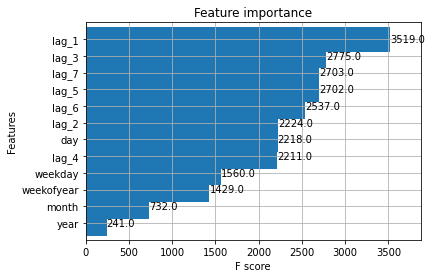

In [57]:
plot_importance(gridcv_xgb, height=1.5)

In [80]:
# RMSE Computation
pred=gridcv_xgb.predict(X_test)
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))

RMSE :  30867.389490


## Miscellaneous Plots

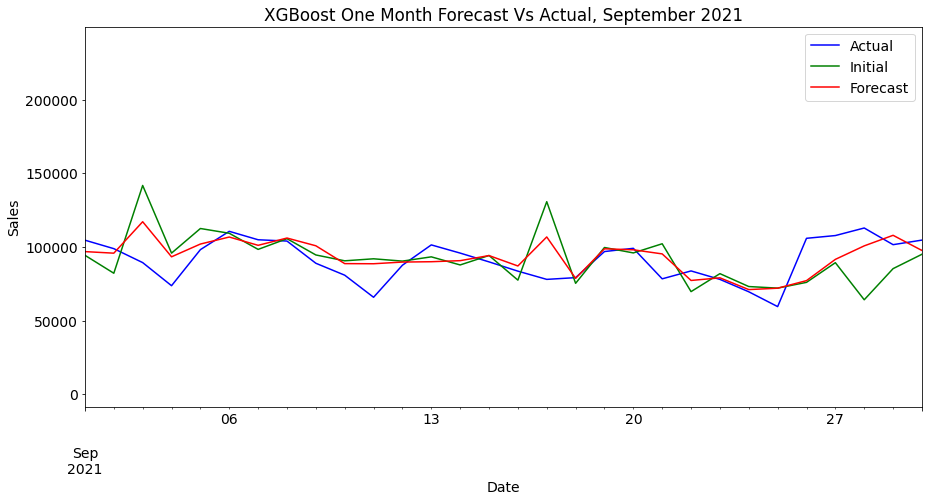

In [96]:
test['Prediction']=gridcv_xgb.predict(X_test)

f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(7)
f.set_figwidth(15)
test.plot(x='date', y='net_revenue', color='b', label='Actual', ax=ax)
test.plot(x='date', y='Initial', color='g', label='Initial', ax=ax)
test.plot(x='date', y='Prediction', color='r', label='Forecast', ax=ax)
plt.legend()
ax.set_xbound(lower=dt.date(2021,9,1), upper=dt.date(2021,9,30))
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('XGBoost One Month Forecast Vs Actual, September 2021')
plt.savefig('images/Forecast XGBoost September.png')

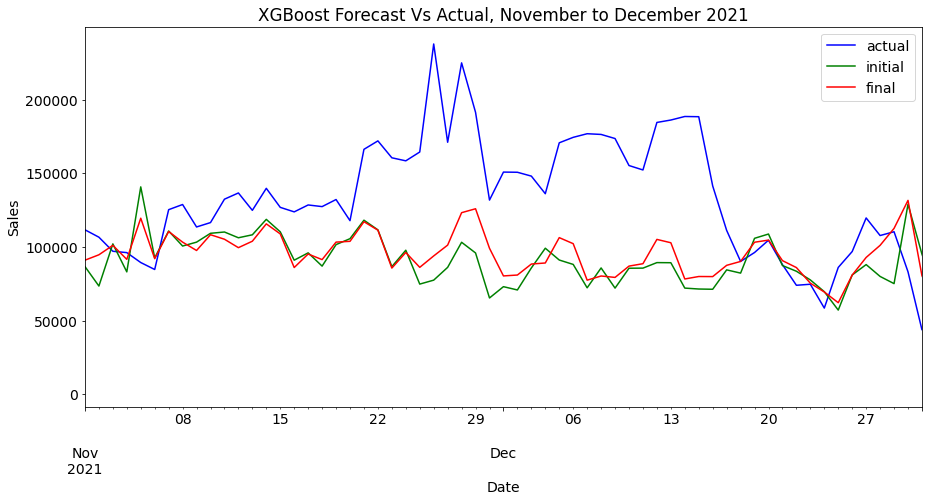

In [95]:
test['Prediction']=gridcv_xgb.predict(X_test)
test['Initial']=xgb_reg.predict(X_test)

f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(7)
f.set_figwidth(15)
test.plot(x='date', y='net_revenue', color='b', label='actual', ax=ax)
test.plot(x='date', y='Initial', color='g', label='initial', ax=ax)
test.plot(x='date', y='Prediction', color='r', label='final', ax=ax)
plt.legend()
ax.set_xbound(lower=dt.date(2021,11,1), upper=dt.date(2021,12,31))
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('XGBoost Forecast Vs Actual, November to December 2021')
plt.savefig('images/Forecast XGBoost Nov-Dec.png')

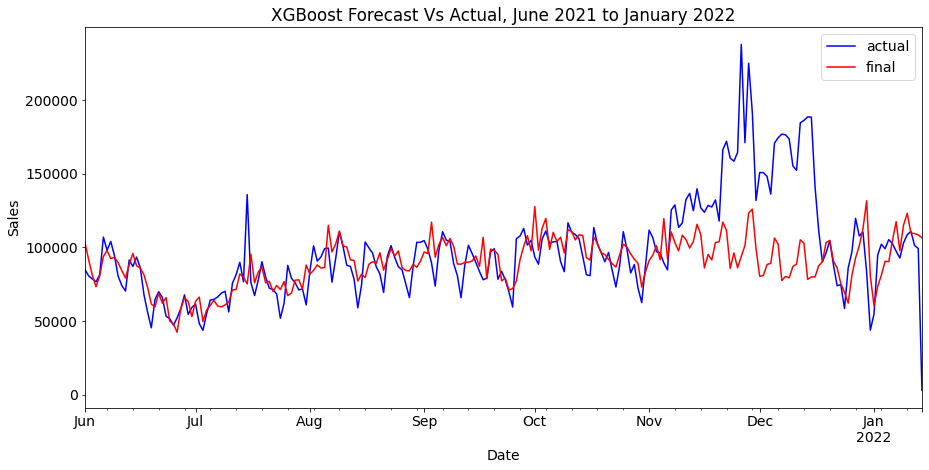

In [99]:
test['Prediction']=gridcv_xgb.predict(X_test)

f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(7)
f.set_figwidth(15)
test.plot(x='date', y='net_revenue', color='b', label='actual', ax=ax)
test.plot(x='date', y='Prediction', color='r', label='final', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('XGBoost Forecast Vs Actual, June 2021 to January 2022')
plt.savefig('images/Forecast XGBoost June-Jan.png')

In [81]:
plt.rcParams.update({'font.size': 14})